In [6]:
import numpy as np
from PIL import Image
from PIL import ImageShow
import time
import torch
from torch.nn import Module, Conv2d, ReLU, MaxPool2d, Flatten, Linear, CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

CLASSES = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class0 = CLASSES.index('cat')
class1 = CLASSES.index('dog')
aux_classes = {CLASSES.index('airplane')}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Model(Module):
    def __init__(self, n_outputs):
        super().__init__()
        self.layers = torch.nn.Sequential(
            Conv2d(3, 32, 3),
            ReLU(),
            MaxPool2d(2, 2),
            Conv2d(32, 64, 3),
            ReLU(),
            MaxPool2d(2, 2),
            Conv2d(64, 32, 4),
            ReLU(),
            Flatten(),
            Linear(288, 64),
            ReLU(),
            Linear(64, n_outputs),
        )

    def forward(self, x):
        return self.layers(x)

target_map = {
    class0: [1.0,0.0],
    class1: [0.0,1.0],
}
ind_test_target_map = {
    class0: 0,
    class1: 1,
}
neutral = [0.5,0.5]
    
train_orig = CIFAR10('data', train=True, transform=ToTensor(), target_transform=lambda c:torch.tensor(target_map.get(c,neutral)), download=True)
indices = [i for i,t in enumerate(train_orig.targets) if t in target_map or t in aux_classes]
train_data = Subset(train_orig, indices)

test_data = CIFAR10('data', train=False, transform=ToTensor(), download=True)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

ind_test_orig = CIFAR10('data', train=False, transform=ToTensor(), target_transform=lambda c:torch.tensor(ind_test_target_map.get(c,neutral)), download=True)
indices = [i for i,t in enumerate(ind_test_orig.targets) if t in target_map]
ind_test_data = Subset(ind_test_orig, indices)
ind_test_dataloader = DataLoader(ind_test_data, batch_size=64, shuffle=False)

model = Model(2).to(device)
opt = torch.optim.Adam(model.parameters(), weight_decay=0.1)
loss = CrossEntropyLoss(reduction='sum')
max_epochs = 30
max_minutes = 5

start_time = time.monotonic()

print(device)

# Training
for epoch in range(max_epochs):
    
    running_loss = torch.zeros(()).to(device)
    running_acc = torch.zeros(()).to(device)
    running_n = 0
    running_acc_n = torch.zeros(()).to(device)
    for X,targets in train_dataloader:
        X = X.to(device)
        targets = targets.to(device)
        opt.zero_grad()
        outputs = model(X)

        loss_value = loss(outputs, targets)
        loss_value.backward()
        opt.step()
        running_loss += loss_value.detach()
        running_n += X.shape[0]
        
        preds = outputs.argmax(dim=1)
        ind = targets.max(dim=1)[0] == 1
        running_acc += ((preds == targets.argmax(dim=1)) & ind).sum()
        running_acc_n += ind.sum()
    print('Epoch', epoch, '   Loss', running_loss.item() / running_n, '    TAcc', running_acc.item() / running_acc_n.item())

    if time.monotonic() - start_time > max_minutes * 60:
        print("Run out of time!")
        break
        
    with torch.no_grad():
        running_acc = torch.zeros(()).to(device)
        running_n = 0
        for X,targets in ind_test_dataloader:
            X = X.to(device)
            targets = targets.to(device)
            
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            #print(preds, targets)
            running_acc += (preds == targets).sum()
            running_n += X.shape[0]
        print('     Accuracy', running_acc.item() / running_n)
print('Time taken', time.monotonic() - start_time, ' seconds')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 0    Loss 0.6883012369791667     TAcc 0.5507
     Accuracy 0.595
Epoch 1    Loss 0.6723240234375     TAcc 0.6045
     Accuracy 0.6115
Epoch 2    Loss 0.6604259114583333     TAcc 0.6377
     Accuracy 0.6575
Epoch 3    Loss 0.6443195963541667     TAcc 0.6717
     Accuracy 0.6605
Epoch 4    Loss 0.6303242838541666     TAcc 0.6851
     Accuracy 0.6895
Epoch 5    Loss 0.6145690104166667     TAcc 0.7103
     Accuracy 0.719
Epoch 6    Loss 0.6015505859375     TAcc 0.723
     Accuracy 0.7285
Epoch 7    Loss 0.5927057942708334     TAcc 0.738
     Accuracy 0.7375
Epoch 8    Loss 0.5862214192708334     TAcc 0.7391
     Accuracy 0.7505
Epoch 9    Loss 0.5770143880208334     TAcc 0.7552
     Accuracy 0.755
Epoch 10    Loss 0.5705324869791667     TAcc 0.7547
     Accuracy 0.753
Epoch 11    Loss 0.5650869140625     TAcc 0.7633
     Accuracy 0.7555
Epoch 12    Loss 0.558081770

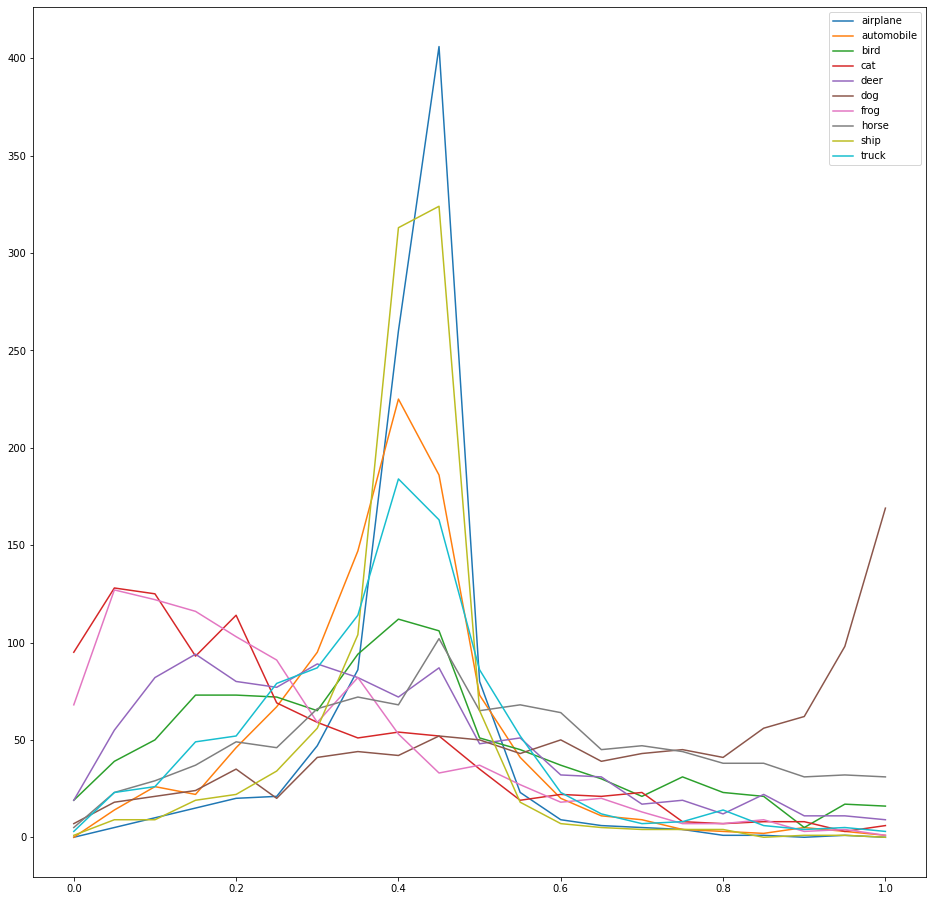

In [7]:
from matplotlib import pyplot as plt

with torch.no_grad():
    probs = np.zeros((len(test_data),))
    targets = np.zeros((len(test_data),))
    i = 0
    for X,y in test_dataloader:
        X = X.to(device)
        j = i + X.shape[0]
        probs[i:j] = model(X).softmax(dim=1)[:,1].to('cpu').numpy()
        targets[i:j] = y
        i = j

    plt.rcParams['figure.figsize'] = [16, 16]
    for i,label in enumerate(CLASSES):
        samples = probs.compress(targets==i, axis=0)
        h, _ = np.histogram(samples, bins=21, range=(0,1))
        plt.plot(np.arange(21)/20, h, label=label)
    plt.legend()

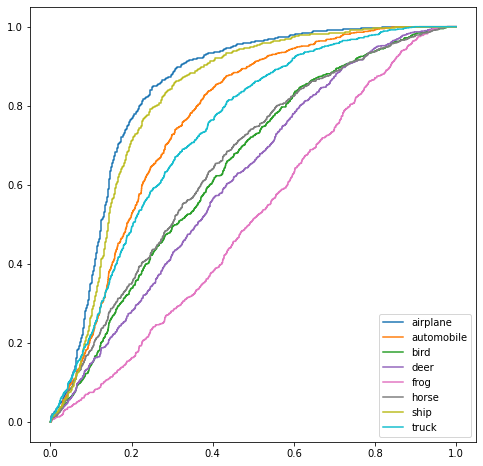

In [8]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay

with torch.no_grad():
    scores = np.zeros((len(test_data),))
    targets = np.zeros((len(test_data),))
    oods = np.zeros((len(test_data),), 'bool')
    i = 0
    for X,y in test_dataloader:
        X = X.to(device)
        j = i + X.shape[0]
        outputs = model(X).softmax(dim=1)[:,1].to('cpu').numpy()
        scores[i:j] = np.minimum(outputs, 1 - outputs)
        targets[i:j] = y
        oods[i:j] = (y != class0) & (y != class1)
        i = j

    plt.rcParams['figure.figsize'] = [8, 8]
    for i,label in enumerate(CLASSES):
        if i == class0 or i == class1:
            # ROC curve doesn't make sense for the in-distribution classes
            plt.plot([], [], label='')
        else:
            keep = (targets == i) | ~oods
            y_true = oods.compress(keep, axis=0)
            y_score = scores.compress(keep, axis=0)
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            plt.plot(fpr, tpr, label=label)
    plt.legend()